# Text analysis of restaurant reviews
## Find hamburgers!

In this notebook we analyze the restaurant reviews for a city and a specific date.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
# hide warnings. `gbq.read_gbq()` gives some
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../scrape_save_search')

import load_data

In [ ]:
df = load_data.load_comments()

# Elastic search

To run Elasticsearch as a service:
+ `brew tap homebrew/services`
+ `brew services start elasticsearch`

You can check that it's up-and-running by examining the logs:
+ `tail -n 15 /usr/local/var/log/elasticsearch.log`


In [13]:
from elasticsearch import Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

In [35]:
# Check if it is running
es.ping()

True

In [56]:
# Check its health
print(es.cat.health(v=True, 
                    h=['timestamp', 'cluster', 'status', 'node.total']))

timestamp cluster            status node.total
10:10:48  elasticsearch_roel yellow          1



In [98]:
# Delete old index if it exists
es.indices.delete(index='restaurant_comments', ignore=404)

{'acknowledged': True}

In [99]:
# Create a new index
es.indices.create(index='restaurant_comments', ignore=400)

{'acknowledged': True,
 'index': 'restaurant_comments',
 'shards_acknowledged': True}

In [100]:
# Define pre-processing and analyzer
hyphens_and_apostrophes_strip = {
    "hyphens_and_apostrophes_strip": {
        "type": "mapping",
        "mappings": [ 
            "- => ' '",
            "' => "
        ]
    }
}

dutch_stop = {
    "dutch_stop": {
        "type": "stop",
        "stopwords": "_dutch_"
    }
}

ngram_tokenizer = {
    "ngram_tokenizer": {
        "type": "ngram",
        "min_gram": 3,
        "max_gram": 4
    }
}

analyzer = {
    "restaurant_comments_analyzer": {
        "type": "custom",
        "char_filter": ["hyphens_and_apostrophes_strip"],
        "tokenizer": "ngram_tokenizer", #"standard",
        "filter": ["lowercase", "dutch_stop", "asciifolding"]
    }
}   

In [101]:
# Apply these on our index 
es.indices.close(index='restaurant_comments')
es.indices.put_settings(
    index='restaurant_comments', 
    body={
        "analysis": {
            "char_filter": hyphens_and_apostrophes_strip,
            "tokenizer": ngram_tokenizer,
            "filter": dutch_stop,
            "analyzer": analyzer
        }
    }
)
es.indices.open(index='restaurant_comments')

{'acknowledged': True, 'shards_acknowledged': True}

In [102]:
# Define what our data looks like
es.indices.put_mapping(
    index='restaurant_comments',
    update_all_types=True,
    doc_type='restaurant_review',
    body={
        "properties": {
            "comment": {
                "type": "text",
                "analyzer": "restaurant_comments_analyzer"
            },
            "name": {
                "type": "keyword"            
            },
            "id": {
                "type": "text"
            },
            "rating": {
                "type": "integer"
            }
        }
    }
)

{'acknowledged': True}

In [106]:
# Add all comments to our index
from elasticsearch.helpers import parallel_bulk
def generate_actions(n_comments):    
    for i in range(n_comments):
        src = {
            'comment': df.loc[i, 'comment'],
            'name': df.loc[i, 'name'],
            'id': str(df.loc[i, 'id']),
            'rating': int(df.loc[i, 'rating_food'])  
        }

        yield {
            '_op_type': 'index',
            '_source': src 
        }

In [107]:
for success, info in parallel_bulk(
    client=es, 
    actions=generate_actions(len(df)),
    index='restaurant_comments', 
    doc_type='restaurant_review',
    thread_count=4):
    if not success: print('Document insertion failed', info)

In [108]:
# Search for 'burger'
res = es.search(
    index='restaurant_comments', 
    doc_type='restaurant_review',
    body={
        "size": 10000,
        "query": {
            "match": {
                "comment": "burger"
            }
        }
    }
)

In [170]:
# Show top results
for i, document in enumerate(res['hits']['hits']):
    print('Score: ', document['_score'])
    pprint(document['_source'], indent=2)
    if i == 1:
        break

Score:  32.29639
{ 'comment': 'Een burger gedaan samen met mijn 5jarige zoon. Serveerster '
             'stelde kinder burger voor. Ik bestelde een gewoon '
             'classic/original met als verzoek geen uien en geen augurk.  '
             'Burgers werden gebracht. En ja hoor vol met uien en augurken '
             'zowel als topping als in de saus vies klef broodje erg zoet van '
             'smaakt burger uitgedroogd. Me zoon een burger zo klein dat hij '
             'zelfs zei papa is dit alles. Friet die er bij zat overladen met '
             'zout en eea kruide. Al met bleek einde van de €33 1burger met '
             'friet 1 cola 1 miniscule burger met friet en appelsap voor die '
             'kwaliteit. Geen burger bitch maar burger bagger',
  'id': '258647',
  'name': 'Burger Bitch',
  'rating': 2,
  'score': 32.29639}
Score:  31.721777
{ 'comment': "Wij zijn met z'n vieren gaan eten bij de Burgermeester. We "
             'werden hartelijk ontvangen en kozen de Spa

In [189]:
# Show result for a restaurant id
for i, document in enumerate(res['hits']['hits']):
#     if document['_source']['id'] == '219507':#'258389':
    if document['_source']['id'] == '256103':
        print('Score: ', document['_score'])
        pprint(document['_source'], indent=2)
        

Score:  22.809015
{ 'comment': 'De Tartiflette was heerlijk en volgens mijn gezelschap was de '
             'Burger Rustique ook geweldig. En vergeet geen dessert te nemen. '
             'De bediening was erg vriendelijk en goed.',
  'id': '256103',
  'name': 'Bistrot des Alpes',
  'rating': 9,
  'score': 22.809015}
Score:  21.6408
{ 'comment': 'De soep van doperwten smaakte niet alleen heerlijk,maar zag er '
             'ook prachtig uit.Daarna een vegaburger,lekkerder dan een gewone '
             'burger.En tot slot een café gourmand,steeds een ander '
             'proefje,heel verassend.Lekkere wijn erbij uit de Haut Savoie.  '
             'Bediening was uitstekend,we kregen veel aandacht en goede '
             'adviezen over de keuze van de wijn.Ze hebben er goed voor '
             'gezorgd dat we op tijd naar Carré konden.  De inrichting van het '
             'restaurant is warm en gezellig,met een oud skiliftje als '
             'loungebar.Het is ietsjes krap allemaal,a

In [ ]:
# Extract info
result = pd.DataFrame(
    [{**x['_source'], 'score': x['_score']} for x in res['hits']['hits']])

In [158]:
# Aggregate per restaurant
restaurant_scores = (
    result
    .groupby('id')['score']
    .agg({'max', 'count'})['max']
    .sort_values()
)

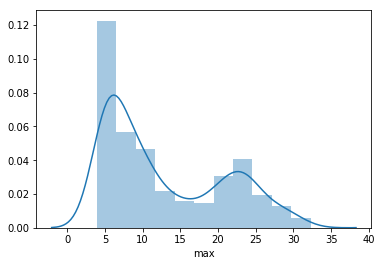

In [159]:
# Plot distribution
sns.distplot(restaurant_scores)

In [180]:
# Select burger restaurants
burger_restaurants = (
    restaurant_scores
    .loc[lambda r: r > 20]
    .reset_index()
    ['id']
)

In [183]:
burger_restaurants.to_csv('elasticsearch_burger_tags.csv', index=False)